In [59]:
import sqlalchemy
import pyodbc
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import requests
import io
import processing_functions
from site_information_class import SiteDataProcessor
from DAL_class_v5 import DAL
%matplotlib inline



In [61]:

'''

site_id = 19505


processor = SiteDataProcessor(
    '../ww_site_info/ww_sites_list.xlsx',
    '../ww_site_info/edm_asset_register.xlsx',
    '../ww_site_info/master_sps_flow_compliance.xlsx'
)

rounded_x, rounded_y = processor.get_rounded_coordinates(site_id)
if rounded_x is not None and rounded_y is not None:
    print(f"Rounded coordinates for SITEID {site_id}: X={rounded_x}, Y={rounded_y}")
else:
    print(f"SITEID {site_id} not found in the data.")

analogue_server, analogue_signal, spill_mm, pre_spill_mm = processor.get_sump_analogue(site_id)
if analogue_server is not None and analogue_signal is not None:
    print(f"Sump level analogue info for SITEID {site_id}:")
    print(f"Analogue Server: {analogue_server}")
    print(f"Analogue Signal: {analogue_signal}")
    print(f"Spill(mm): {spill_mm}")
    print(f"Pre-Spill (mm): {pre_spill_mm}")
else:
    print(f"SITEID {site_id} not found in the asset register data.")

server, db_addr, db_name = processor.get_flowmeter_signals(site_id)
if server is not None and db_addr is not None and db_name is not None:
    print(f"Flowmeter signal information for Site Id {site_id}:")
    print(f"Flowmeter Server: {server}")
    print(f"DB_ADDR: {db_addr}")
    print(f"DB_NAME: {db_name}")
else:
    print(f"Site Id {site_id} not found in the flowmeter signals data.")

'''

'\n\nsite_id = 19505\n\n\nprocessor = SiteDataProcessor(\n    \'../ww_site_info/ww_sites_list.xlsx\',\n    \'../ww_site_info/edm_asset_register.xlsx\',\n    \'../ww_site_info/master_sps_flow_compliance.xlsx\'\n)\n\nrounded_x, rounded_y = processor.get_rounded_coordinates(site_id)\nif rounded_x is not None and rounded_y is not None:\n    print(f"Rounded coordinates for SITEID {site_id}: X={rounded_x}, Y={rounded_y}")\nelse:\n    print(f"SITEID {site_id} not found in the data.")\n\nanalogue_server, analogue_signal, spill_mm, pre_spill_mm = processor.get_sump_analogue(site_id)\nif analogue_server is not None and analogue_signal is not None:\n    print(f"Sump level analogue info for SITEID {site_id}:")\n    print(f"Analogue Server: {analogue_server}")\n    print(f"Analogue Signal: {analogue_signal}")\n    print(f"Spill(mm): {spill_mm}")\n    print(f"Pre-Spill (mm): {pre_spill_mm}")\nelse:\n    print(f"SITEID {site_id} not found in the asset register data.")\n\nserver, db_addr, db_name = pr

In [63]:
'''
easting_value = rounded_x  # or specify alternative 316500
northing_value = rounded_y # 121500

DBAddr_sump = 11943#  analogue_signal[1:]  
print(DBAddr_sump)
SourceSystem_sump = 'WASTE'# analogue_server  #make sure this is capitalized
print(SourceSystem_sump)
DBAddr_flow_meter = db_addr
print(DBAddr_flow_meter)
sourcesystem_flow_meter = server #'WASTE'
print(sourcesystem_flow_meter)

'''

"\neasting_value = rounded_x  # or specify alternative 316500\nnorthing_value = rounded_y # 121500\n\nDBAddr_sump = 11943#  analogue_signal[1:]  \nprint(DBAddr_sump)\nSourceSystem_sump = 'WASTE'# analogue_server  #make sure this is capitalized\nprint(SourceSystem_sump)\nDBAddr_flow_meter = db_addr\nprint(DBAddr_flow_meter)\nsourcesystem_flow_meter = server #'WASTE'\nprint(sourcesystem_flow_meter)\n\n"

In [65]:

'''

queries = processing_functions.read_queries('queries_v3.sql')
query1 = queries['query1']
query2 = queries['query2']
query3 = queries['query3']
query4 = queries['query4']
query5 = queries['query5']



    
site_id = 19505
start_date = datetime(2024, 5, 23) #year, month, day
end_date = datetime(2024, 5, 25) #year, month, day

# Convert dates to string format 'YYYY-MM-DD'
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')


# Define your queries
query_formatted_rainfall = query1.format(easting=easting_value, northing=northing_value, start_date=start_date_str, end_date=end_date_str)
query_formatted_raw_sump = query2.format(start_date=start_date_str, end_date=end_date_str, DBAddr_sump=DBAddr_sump, SourceSystem_sump=SourceSystem_sump)
query_formatted_hour_agg_flow_meter = query3.format(start_date=start_date_str, end_date=end_date_str, DBAddr_flow_meter=DBAddr_flow_meter , sourcesystem_flow_meter=sourcesystem_flow_meter)
query_formatted_daily_agg_sump = query4.format(start_date=start_date_str, end_date=end_date_str, DBAddr_sump=DBAddr_sump, SourceSystem_sump=SourceSystem_sump)
query_formatted_raw_flow_meter = query5.format(start_date=start_date_str, end_date=end_date_str, DBAddr_flow_meter=DBAddr_flow_meter , sourcesystem_flow_meter=sourcesystem_flow_meter)



# Execute queries and get dataframes
df_rainfall = processing_functions.execute_query_and_return_df("DALMeteorology", query_formatted_rainfall)
df_raw_sump = processing_functions.execute_query_and_return_df("sqlTelemetry", query_formatted_raw_sump)
df_hour_agg_flow_meter = processing_functions.execute_query_and_return_df("sqlTelemetry", query_formatted_hour_agg_flow_meter)
df_daily_agg_sump = processing_functions.execute_query_and_return_df("sqlTelemetry", query_formatted_daily_agg_sump)
df_raw_flow_meter = processing_functions.execute_query_and_return_df("sqlTelemetry", query_formatted_raw_flow_meter)


# Print the head(5) of each dataframe and save to xlsx
if df_rainfall is not None:
    print("Head of df_rainfall:")
    print(df_rainfall.head(5))
    df_rainfall.to_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_rainfall.xlsx', index=False)

if df_raw_sump is not None:
    print("Head of df_raw_sump:")
    print(df_raw_sump.head(5))
    df_raw_sump.to_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_sump.xlsx', index=False)



if df_hour_agg_flow_meter is not None:
    print("Head of df_hour_agg_flow_meter:")
    print(df_hour_agg_flow_meter.head(5))
    df_hour_agg_flow_meter.to_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_hour_agg_flow_meter.xlsx', index=False)


if df_daily_agg_sump is not None:
    print("Head of df_daily_agg_sump:")
    print(df_daily_agg_sump.head(5))
    df_daily_agg_sump.to_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_daily_agg_sump.xlsx', index=False)



if df_raw_flow_meter is not None:
    print("Head of df_raw_flow_meter:")
    print(df_raw_flow_meter.head(5))
    df_raw_flow_meter.to_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_flow_meter.xlsx', index=False)
'''

'\n\nqueries = processing_functions.read_queries(\'queries_v3.sql\')\nquery1 = queries[\'query1\']\nquery2 = queries[\'query2\']\nquery3 = queries[\'query3\']\nquery4 = queries[\'query4\']\nquery5 = queries[\'query5\']\n\n\n\n    \nsite_id = 19505\nstart_date = datetime(2024, 5, 23) #year, month, day\nend_date = datetime(2024, 5, 25) #year, month, day\n\n# Convert dates to string format \'YYYY-MM-DD\'\nstart_date_str = start_date.strftime(\'%Y-%m-%d\')\nend_date_str = end_date.strftime(\'%Y-%m-%d\')\n\n\n# Define your queries\nquery_formatted_rainfall = query1.format(easting=easting_value, northing=northing_value, start_date=start_date_str, end_date=end_date_str)\nquery_formatted_raw_sump = query2.format(start_date=start_date_str, end_date=end_date_str, DBAddr_sump=DBAddr_sump, SourceSystem_sump=SourceSystem_sump)\nquery_formatted_hour_agg_flow_meter = query3.format(start_date=start_date_str, end_date=end_date_str, DBAddr_flow_meter=DBAddr_flow_meter , sourcesystem_flow_meter=sourcesys

Only neet to use this if you don't aleady have the dataframes loaded in

In [90]:


# Function to load dataframes from xlsx files if they are not already loaded
def load_dataframes(site_id, start_date_str, end_date_str):
    df_raw_sump = None
    df_raw_flow_meter = None
    df_rainfall = None
    df_hour_agg_flow_meter = None
    df_daily_agg_sump = None

    try:
        df_raw_sump = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_sump.xlsx')
        print("Loaded df_raw_sump from xlsx file.")
    except FileNotFoundError:
        print("df_raw_sump xlsx file not found.")

    try:
        df_raw_flow_meter = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_raw_flow_meter.xlsx')
        print("Loaded df_raw_flow_meter from xlsx file.")
    except FileNotFoundError:
        print("df_raw_flow_meter xlsx file not found.")

    try:
        df_rainfall = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_rainfall.xlsx')
        print("Loaded df_rainfall from xlsx file.")
    except FileNotFoundError:
        print("df_rainfall xlsx file not found.")

    try:
        df_hour_agg_flow_meter = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_hour_agg_flow_meter.xlsx')
        print("Loaded df_hour_agg_flow_meter from xlsx file.")
    except FileNotFoundError:
        print("df_hour_agg_flow_meter xlsx file not found.")

    try:
        df_daily_agg_sump = pd.read_excel(f'../data/raw/site{site_id}_from_{start_date_str}_to_{end_date_str}_daily_agg_sump.xlsx')
        print("Loaded df_daily_agg_sump from xlsx file.")
    except FileNotFoundError:
        print("df_daily_agg_sump xlsx file not found.")

    return df_raw_sump, df_raw_flow_meter, df_rainfall, df_hour_agg_flow_meter, df_daily_agg_sump

# Example usage
site_id = 19505
start_date_str = "2024-05-23"
end_date_str = "2024-05-25"

df_raw_sump, df_raw_flow_meter, df_rainfall, df_hour_agg_flow_meter, df_daily_agg_sump = load_dataframes(site_id, start_date_str, end_date_str)


Loaded df_raw_sump from xlsx file.
df_raw_flow_meter xlsx file not found.
Loaded df_rainfall from xlsx file.
Loaded df_hour_agg_flow_meter from xlsx file.
df_daily_agg_sump xlsx file not found.


In [104]:
# Print the head(5) of each dataframe and save to xlsx
if df_raw_sump is not None:
    print("Head of df_raw_sump:")
    print(df_raw_sump.head(5))



Head of df_raw_sump:
              TimeGMT       date  SourceSystemId  DbAddr        DbName  \
0 2024-05-23 01:00:00 2024-05-23               1   11943  Default Name   
1 2024-05-23 01:05:00 2024-05-23               1   11943  Default Name   
2 2024-05-23 01:10:00 2024-05-23               1   11943  Default Name   
3 2024-05-23 01:15:00 2024-05-23               1   11943  Default Name   
4 2024-05-23 01:20:00 2024-05-23               1   11943  Default Name   

      EValue  Year  Month  Day  
0   9.737305  2024      5   23  
1  11.346680  2024      5   23  
2  10.181152  2024      5   23  
3   7.141602  2024      5   23  
4   9.409668  2024      5   23  


In [94]:
if df_hour_agg_flow_meter is not None:
    print("Head of df_hour_agg_flow_meter:")
    print(df_hour_agg_flow_meter.head(5))

Head of df_hour_agg_flow_meter:
   Hour  DbAddr  count  meanEValue  stddev_EValue  Year  Month  Day
0     0   11726     60       11.13      25.522881  2024      5   23
1     1   11726     60        9.35      23.755134  2024      5   23
2     2   11726     60        4.50      17.186139  2024      5   23
3     3   11726     60       10.33      26.012200  2024      5   23
4     4   11726     60        9.07      24.852179  2024      5   23


In [96]:
if df_raw_flow_meter is not None:
    print("Head of df_raw_flow_meter:")
    print(df_raw_flow_meter.head(5))


In [98]:

if df_rainfall is not None:
    print("Head of df_rainfall:")
    print(df_rainfall.head(5))
df_rainfall['timestamp'] = pd.to_datetime(df_rainfall['ReadingDate'], format='%Y%m%d%H%M')
print(df_rainfall.head(5))

Head of df_rainfall:
    ReadingDate  Easting  Northing  Intensity(mm/hr)  Depth(mm)  Year  Month  \
0  202405240520   337500    161500              0.01       0.06  2024      5   
1  202405240550   337500    161500              0.02       0.19  2024      5   
2  202405240430   337500    161500              0.00       0.03  2024      5   
3  202405240440   337500    161500              0.00       0.03  2024      5   
4  202405240600   337500    161500              0.00       0.03  2024      5   

   Day  
0   24  
1   24  
2   24  
3   24  
4   24  
    ReadingDate  Easting  Northing  Intensity(mm/hr)  Depth(mm)  Year  Month  \
0  202405240520   337500    161500              0.01       0.06  2024      5   
1  202405240550   337500    161500              0.02       0.19  2024      5   
2  202405240430   337500    161500              0.00       0.03  2024      5   
3  202405240440   337500    161500              0.00       0.03  2024      5   
4  202405240600   337500    161500          

In [100]:

from IPython.display import display, clear_output
import ipywidgets as widgets

start_time_plot = "2024-05-23 00:00:00"
end_time_plot = "2024-05-25 00:00:00"

df_sump_filtered = df_raw_sump
df_rainfall_filtered = df_rainfall

def plot_rainfall_and_sump_level(start_time, end_time):
    # Convert start and end times to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # Filter the dataframes based on the specified time interval
    df_sump_filtered = df_raw_sump[(df_raw_sump["TimeGMT"] >= start_time) & (df_raw_sump["TimeGMT"] <= end_time)]
    df_rainfall_filtered = df_rainfall[(df_rainfall["timestamp"] >= start_time) & (df_rainfall["timestamp"] <= end_time)]

    # Sort the filtered dataframes by their respective time columns
    df_sump_filtered = df_sump_filtered.sort_values(by="TimeGMT")
    df_rainfall_filtered = df_rainfall_filtered.sort_values(by="timestamp")

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot sump level on the first y-axis
    ax1.plot(df_sump_filtered["TimeGMT"], df_sump_filtered["EValue"], color='green', label='Sump Level')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Sump Level', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # Create a second y-axis for rainfall
    ax2 = ax1.twinx()
    ax2.plot(df_rainfall_filtered["timestamp"], df_rainfall_filtered["Intensity(mm/hr)"], color='blue', label='Rainfall')
    ax2.set_ylabel('Rainfall intensity (mm/h)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and grid
    plt.title('Rainfall and Sump Level Over Time')
    fig.tight_layout()
    plt.grid(True)

    # Show the plot
    plt.show()





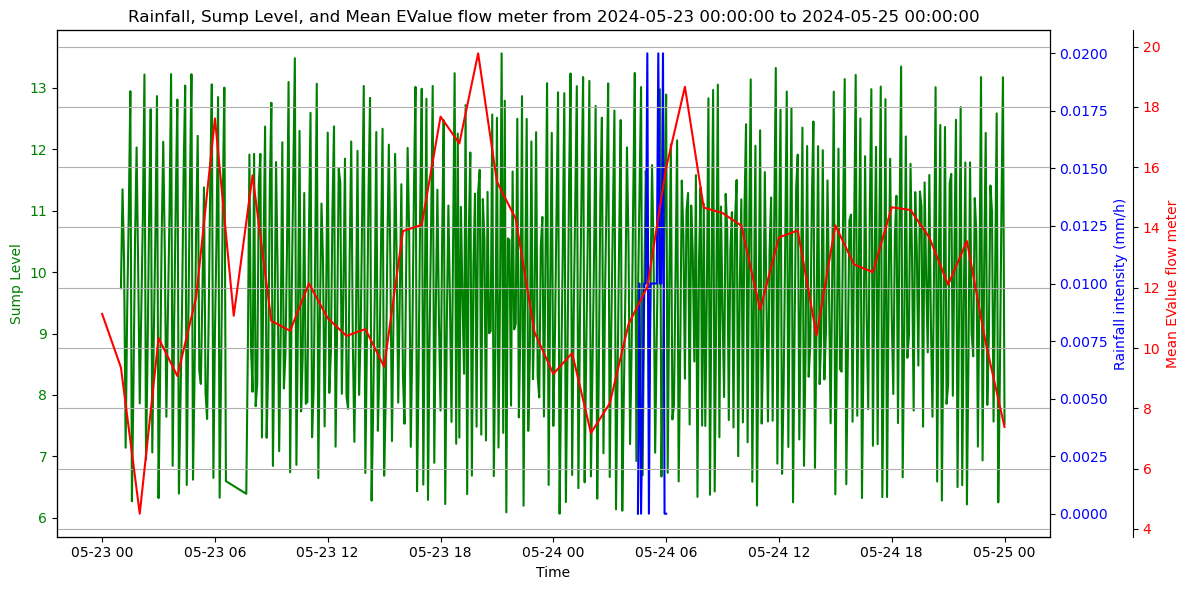

In [108]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import processing_functions




start_time_plot = "2024-05-23 00:00:00"
end_time_plot = "2024-05-25 00:00:00"


df_sump_filtered = df_raw_sump
df_rainfall_filtered = df_rainfall
df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter

def plot_rainfall_mean_agg_flow_meter_and_raw_sump_level(start_time, end_time):
    # Convert start and end times to datetime
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # Filter the dataframes based on the specified time interval
    df_sump_filtered = df_raw_sump[(df_raw_sump["TimeGMT"] >= start_time) & (df_raw_sump["TimeGMT"] <= end_time)]
    df_rainfall_filtered = df_rainfall[(df_rainfall["timestamp"] >= start_time) & (df_rainfall["timestamp"] <= end_time)]
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter[
        (pd.to_datetime(df_hour_agg_flow_meter["Year"].astype(str) + '-' + df_hour_agg_flow_meter["Month"].astype(str) + '-' + df_hour_agg_flow_meter["Day"].astype(str) + ' ' + df_hour_agg_flow_meter["Hour"].astype(str) + ':00:00') >= start_time) & 
        (pd.to_datetime(df_hour_agg_flow_meter["Year"].astype(str) + '-' + df_hour_agg_flow_meter["Month"].astype(str) + '-' + df_hour_agg_flow_meter["Day"].astype(str) + ' ' + df_hour_agg_flow_meter["Hour"].astype(str) + ':00:00') <= end_time)
    ]

    # Sort the filtered dataframes by their respective time columns
    df_sump_filtered = df_sump_filtered.sort_values(by="TimeGMT")
    df_rainfall_filtered = df_rainfall_filtered.sort_values(by="timestamp")
    df_hour_agg_flow_meter_filtered = df_hour_agg_flow_meter_filtered.sort_values(by=["Year", "Month", "Day", "Hour"])

    # Create a figure and axis objects
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot sump level on the first y-axis
    ax1.plot(df_sump_filtered["TimeGMT"], df_sump_filtered["EValue"], color='green', label='Sump Level')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Sump Level', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # Create a second y-axis for rainfall
    ax2 = ax1.twinx()
    ax2.plot(df_rainfall_filtered["timestamp"], df_rainfall_filtered["Intensity(mm/hr)"], color='blue', label='Rainfall')
    ax2.set_ylabel('Rainfall intensity (mm/h)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Create a third y-axis for meanEValue
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to the right
    ax3.plot(
        pd.to_datetime(df_hour_agg_flow_meter_filtered["Year"].astype(str) + '-' + df_hour_agg_flow_meter_filtered["Month"].astype(str) + '-' + df_hour_agg_flow_meter_filtered["Day"].astype(str) + ' ' + df_hour_agg_flow_meter_filtered["Hour"].astype(str) + ':00:00'), 
        df_hour_agg_flow_meter_filtered["meanEValue"], color='red', label='Mean EValue'
    )
    ax3.set_ylabel('Mean EValue flow meter', color='red')
    ax3.tick_params(axis='y', labelcolor='red')

    # Add title and grid
    plt.title(f'Rainfall, Sump Level, and Mean EValue flow meter from {start_time_plot} to {end_time_plot}')
    fig.tight_layout()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
plot_rainfall_mean_agg_flow_meter_and_raw_sump_level(start_time_plot, end_time_plot)


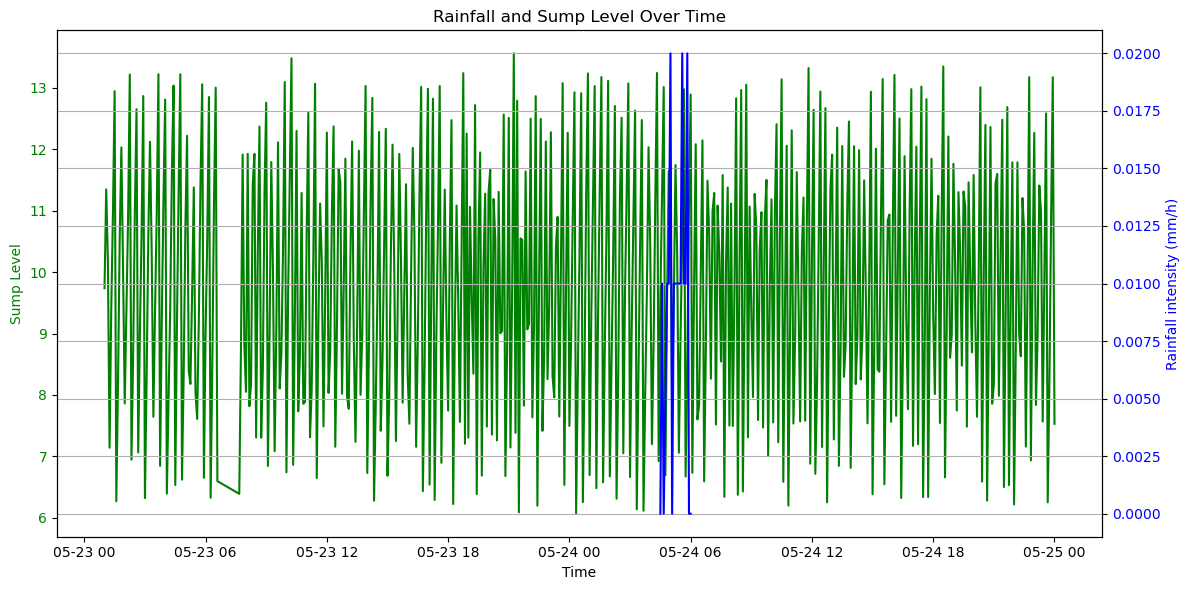

In [82]:
# Runs the above function given the timeframe to produce a time series plot


plot_rainfall_and_sump_level(start_time_plot, end_time_plot)

